In [1]:
import os
import random
import time
from collections import deque
import tensorflow as tf
from resources.Plots import plot_actions
from resources.Utils import load_object, store_object
import resources.Utils as utils
print(tf.__version__)
import numpy as np

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\ten

1.10.0


In [2]:
class MemoryBuffer:
    def __init__(self, max, id, init_size=5000):
        self.memory = deque([], maxlen=max)
        self.id = "memory_{}.obj".format(id)
        self.init_size = init_size

    def store(self, state, action, reward, nstate, done):
        # Store the experience in memory
        if len(self.memory) < self.memory.maxlen:
            self.memory.append((state, action, reward, nstate, done))
        else:
            self.memory.popleft()
            self.memory.append((state, action, reward, nstate, done))

    def init_memory(self, env, load=False):
        # time measurement for memory initialization
        init_time = time.time()
        # resetting environment once
        state = env.reset()
        # try to load memory from local file
        if os.path.isfile(self.id) and load:
            self.memory = load_object(self.id)
        # try to init memory by taking random steps in our environment until the deque is full
        else:
            while True:
                # break if memory is full
                if len(self.memory) >= self.init_size:
                    break
                # check if we need to reset env and still fill our memory
                if env.is_done():
                    env.reset()
                # get random action
                action = random.randrange(env.action_space_n)
                # take step in env and append
                nstate, reward, done, [] = env.step(action)
                # store our memory in class
                self.store(state, action, reward, nstate, done)
                state = nstate[action]
            # store our memory locally to reduce loading time on next run
            store_object(self.memory, self.id)
            print("Memory is full, {} Samples stored. It took {} seconds".format(len(self.memory),
                                                                                 time.time() - init_time))

    def get_exp(self, batch_size):
        # Popping from the Memory Queue which should be filled randomly beforehand
        if len(self.memory) > batch_size:
            samples = [self.memory.popleft() for _i in range(batch_size)]
            for sample in samples:
                self.memory.append(sample)
        else:
            raise Exception(
                "There are only {} samples left, batch size of {} is too big.".format(len(self.memory), batch_size))
        return samples

    def __len__(self):
        return len(self.memory)

In [3]:
class Simulator:
    """
    This class is used to train and to test the agent in its environment
    """

    def __init__(self, max_episodes, agent, environment, update_steps):
        """
        Initialize the Simulator with parameters

        :param max_episodes: How many episodes we want to learn, the last episode is used for evaluation
        :param agent: the agent which should be trained
        :param environment: the environment to evaluate and train in
        :param update_steps: the update steps for the Target Q-Network of the Agent
        """
        self.max_episodes = max_episodes
        self.episode = 0
        self.agent = agent
        self.env = environment
        self.update_steps = update_steps

        # information variables
        self.training_scores = []
        self.test_rewards = []
        self.test_actions = []

    def run(self):
        """
        This method is for scheduling training before testing
        :return: True if finished
        """
        while True:
            start = utils.start_timer()
            start_testing = self.__can_test()
            if not start_testing:
                info = self.__training_iteration()
                print("Training episode {} took {} seconds {}".format(self.episode, utils.get_duration(start), info))
                self.__next__()
            if start_testing:
                self.__testing_iteration()
                print("Testing episode {} took {} seconds".format(self.episode, utils.get_duration(start)))
                break
            print(self.agent.epsilon)
            self.agent.anneal_epsilon()
        plot_actions(self.test_actions[0], getattr(self.env, "timeseries_labeled"))
        return True

    def __training_iteration(self):
        """
        One training iteration is through the complete timeseries, maybe this needs to be changed for
        bigger timeseries datasets.

        :return: Information of the training episode, if update episode or normal episode
        """
        rewards = 0
        state = self.env.reset()
        for idx in range(len(
                self.env)):
            action = self.agent.action(state)
            nstate, reward, done, [] = env.step(action)
            rewards += reward[action]
            self.agent.memory.store(state, action, reward, nstate, done)
            state = nstate[action]
            if done:
                self.training_scores.append(rewards)
                print("Training Score now: ", np.sum(rewards))
                self.agent.update_target_model()
                break

        if len(self.agent.memory) > self.agent.batch_size:
            self.agent.experience_replay()

        # Target Model Update
        # if self.episode % self.update_steps == 0:
        #     self.agent.update_target_model()
        #     return "Update Target Model"
        return ""

    def __testing_iteration(self):
        """
        The testing iteration with greedy actions only.
        """
        rewards = 0
        actions = []
        state = self.env.reset()
        self.agent.epsilon = 0
        for idx in range(len(
                self.env)):
            action = self.agent.action(state)
            actions.append(action)
            nstate, reward, done, [] = env.step(action)
            rewards += reward[action]
            state = nstate[action]
            if done:
                actions.append(action)
                self.test_rewards.append(rewards)
                self.test_actions.append(actions)
                break

    def __can_test(self):
        """
        :return: True if last episode, False before
        """
        if self.episode >= self.max_episodes:
            return True
        return False

    def __next__(self):
        # increment episode counter
        self.episode += 1

In [4]:
from agents.BinaryStateAgent import BinaryStateAgent
from agents.NeuralNetwork import NeuralNetwork
from environment.BinaryStateEnvironment import BinaryStateEnvironment
from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment

#tf.compat.v1.disable_eager_execution()
config = ConfigTimeSeries()
env = BinaryStateEnvironment(
    TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData.csv", config=config))

dqn = NeuralNetwork(input_dim=env.steps,
                input_neurons=env.steps, hidden_neurons=128, type="lstm_binary").keras_model
agent = BinaryStateAgent(dqn=dqn, memory=MemoryBuffer(max=50000, id="binary_agent"), alpha=0.0001, gamma=0.9, \
                         epsilon=1.0, epsilon_end=0.0, epsilon_decay=0.9, fit_epoch=1, action_space=2, \
                         batch_size=512)

TimeSeries from: ./Test/SmallData.csv
 Header(labeled):
    value  anomaly
0  12183        0
1  12715        0
2  12736        0 
Header(unlabeled):
    value
0  12183
1  12715
2  12736 
Rows:
 1439
MeanValue:
 11020.08
MaxValue:
 170029
MinValue:
 3594
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 5)              160       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            268288    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 271,010
Trainable params: 271,010
Non-trainable params: 0
_________________________________________________________________


C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Successfully stored to memory_binary_agent.obj
Memory is full, 5000 Samples stored. It took 0.4109013080596924 seconds
Training Score now:  -3
Training episode 0 took 3.7452681064605713 seconds 
1.0
Training Score now:  145
Training episode 1 took 0.6933259963989258 seconds 
0.9
Training Score now:  257
Training episode 2 took 0.7566149234771729 seconds 
0.81
Training Score now:  411
Training episode 3 took 0.8545854091644287 seconds 
0.7290000000000001
Training Score now:  477
Training episode 4 took 0.9751074314117432 seconds 
0.6561000000000001
Training Score now:  515
Training episode 5 took 1.0647869110107422 seconds 
0.5904900000000002
Training Score now:  645
Training episode 6 took 1.1601982116699219 seconds 
0.5314410000000002
Training Score now:  673
Training episode 7 took 1.2110695838928223 seconds 
0.47829690000000014
Training Score now:  739
Training episode 8 took 1.2622416019439697 seconds 
0.43046721000000016
Training Score now:  817
Training episode 9 took 1.356896877

ValueError: x and y must have same first dimension, but have shapes (1439,) and (1434,)

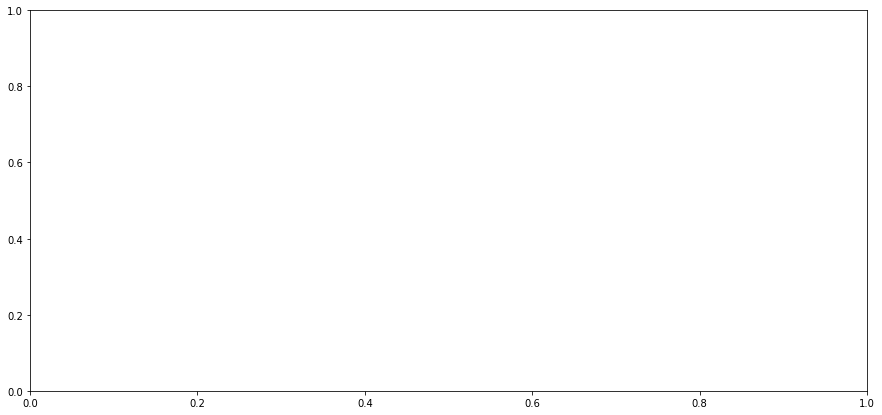

In [5]:
simulation = Simulator(10, agent, env, 1)
agent.memory.init_memory(env=env)
simulation.run()